This file is investigating MobileNetV2 pre trained model for our tree classification task. The base implementation is working, however in the project work we did not pursue any serious investigation with pre trained models and only wanted to use it as an initial benchmark. So, the results here are not presented nor reported.

In [1]:
import os
import ast
import h5py
import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16



In [2]:
input_file = "data/combined_data.geojson"
## Read combined data
combined_gdf = gpd.read_file(input_file)

In [3]:
print(combined_gdf.head())
print(combined_gdf.crs)
print(combined_gdf.columns.to_list())
combined_gdf.crs = "EPSG:25832"
print(combined_gdf.crs)
print(combined_gdf.shape)

                     id                                                B11  \
0  0000000000000000050b  [ [ 0.23570001125335693, 0.23570001125335693, ...   
1  0000000000000000050c  [ [ 0.31589999794960022, 0.31589999794960022, ...   
2  0000000000000000050d  [ [ 0.19909998774528503, 0.18310000002384186, ...   
3  0000000000000000050e  [ [ 0.22779999673366547, 0.22419999539852142, ...   
4  0000000000000000050f  [ [ 0.25600001215934753, 0.26150000095367432, ...   

                                               B11_1  \
0                                               None   
1  [ [ 0.33454999327659607, 0.33454999327659607, ...   
2  [ [ 0.25055000185966492, 0.2463500052690506, 0...   
3  [ [ 0.26010000705718994, 0.25749999284744263, ...   
4  [ [ 0.28685000538825989, 0.29079997539520264, ...   

                                               B11_2  \
0  [ [ 0.25260001420974731, 0.25260001420974731, ...   
1  [ [ 0.36035001277923584, 0.36035001277923584, ...   
2  [ [ 0.33680000901222229

In [4]:
# for now, we just select the NDVI, and keep id&species
select_col = ['l1_leaf_types', 'l2_genus','l3_species', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7']

select_df = combined_gdf[select_col]

In [5]:
# for now we just dorp the None
combined_gdf_cleaned = select_df.dropna().reset_index(drop=True)
print(combined_gdf_cleaned.shape)
print(combined_gdf_cleaned.isnull().any())

(26268, 43)
l1_leaf_types    False
l2_genus         False
l3_species       False
EVI              False
EVI2             False
EVI2_1           False
EVI2_2           False
EVI2_3           False
EVI2_4           False
EVI2_5           False
EVI2_6           False
EVI2_7           False
EVI_1            False
EVI_2            False
EVI_3            False
EVI_4            False
EVI_5            False
EVI_6            False
EVI_7            False
NDVI             False
NDVI_1           False
NDVI_2           False
NDVI_3           False
NDVI_4           False
NDVI_5           False
NDVI_6           False
NDVI_7           False
NDWI             False
NDWI_1           False
NDWI_2           False
NDWI_3           False
NDWI_4           False
NDWI_5           False
NDWI_6           False
NDWI_7           False
SAVI             False
SAVI_1           False
SAVI_2           False
SAVI_3           False
SAVI_4           False
SAVI_5           False
SAVI_6           False
SAVI_7           False

In [6]:
# load the labels
labels = np.array(combined_gdf_cleaned[['l3_species']])
sen2 = np.array(combined_gdf_cleaned[['l1_leaf_types', 'l2_genus', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7']])
# show the shape
print("Labels shape: " + str(labels.shape))
#print("Sen2 shape: " + str(sen2.shape))

# print the labels
print(labels[:])
print(sen2[:])
print(sen2.shape)

Labels shape: (26268, 1)
[['european beech']
 ['european beech']
 ['european beech']
 ...
 ['scots pine']
 ['scots pine']
 ['scots pine']]
[['broadleaf' 'beech'
  '[ [ 0.20749008911810152, 0.20749008911810152, 0.19399448468637809, 0.19399448468637809, 0.17264941854954027 ], [ 0.18811365650919964, 0.18811365650919964, 0.1849789855605749, 0.1849789855605749, 0.16339870893377503 ], [ 0.15306353645981172, 0.17718141664517226, 0.21298995013305966, 0.21298995013305966, 0.1739566666446915 ], [ 0.19121085741222177, 0.2207476943381205, 0.22820864778601127, 0.22820864778601127, 0.18666553060357882 ], [ 0.28203077196510823, 0.27142411560406604, 0.2212287710345307, 0.2212287710345307, 0.18814043369977704 ] ]'
  ...
  '[ [ 0.35093790837565908, 0.35093790837565908, 0.31429786378906566, 0.31429786378906566, 0.28788278548797042 ], [ 0.2948440487682471, 0.2948440487682471, 0.29643140302789217, 0.29643140302789217, 0.26059503130689377 ], [ 0.27335232700838136, 0.25345287282008022, 0.29461244520828722, 0

In [7]:
labels_raw = np.array(combined_gdf_cleaned['l3_species'])
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_l3 = encoder.fit_transform(labels_raw.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")
print(labels_l3[:10])

print("Unique species in first 19 samples:")
print(combined_gdf_cleaned['l3_species'][:19].unique())

print("\nAll unique species:")
print(combined_gdf_cleaned['l3_species'].unique())

print("\nSpecies distribution:")
print(combined_gdf_cleaned['l3_species'].value_counts())

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Unique species in first 19 samples:
['european beech']

All unique species:
['european beech' 'linden' 'cherry' 'sycamore maple' 'european ash'
 'english oak' 'sessile oak' 'red oak' 'alder' 'poplar' 'birch'
 'douglas fir' 'silver fir' 'japanese larch' 'european larch' 'black pine'
 'weymouth pine' 'norway spruce' 'scots pine']

Species distribution:
l3_species
scots pine        4260
norway spruc

In [8]:
# Print Sentinel-2 data
print("Sentinel-2 shape: " + str(sen2.shape))
sen2_depot = sen2 # so that I dont need to rerun the whole thing

Sentinel-2 shape: (26268, 42)


In [9]:
# Function to process numerical arrays only
def convert_string_to_array(s):
	if isinstance(s, str) and s.startswith('['):
		try:
			# Using ast.literal_eval to safely evaluate the string as a Python literal
			array_data = ast.literal_eval(s)
			return np.array(array_data).flatten()
		except:
			return None
	return None

# Get indices of columns containing string arrays
numerical_indices = []
for i in range(2, sen2.shape[1]):  # Skip first two columns (leaf type and genus)
	if isinstance(sen2[0, i], str) and sen2[0, i].startswith('['):
		numerical_indices.append(i)

# Process only the numerical array columns
processed_arrays = []
for row in sen2:
	row_data = []
	for idx in numerical_indices:
		arr = convert_string_to_array(row[idx])
		if arr is not None:
			row_data.extend(arr)
	processed_arrays.append(row_data)

sen2_reshaped = np.array(processed_arrays)

print("Post-processed Sentinel-2 data shape: ", sen2_reshaped.shape)
if sen2_reshaped.size > 0:
	print("Post-processed Sentinel-2 data type:", type(sen2_reshaped[0][0]))
	print("First row shape:", sen2_reshaped[0].shape)

Post-processed Sentinel-2 data shape:  (26268, 1000)
Post-processed Sentinel-2 data type: <class 'numpy.float64'>
First row shape: (1000,)


In [10]:
# Get the number of samples and features
n_samples = sen2_reshaped.shape[0]
n_features = sen2_reshaped.shape[1]

# Create array with shape (n_samples, 5, 5, 40)
X_reshaped = np.zeros((n_samples, 5, 5, 40))

# Reshape the data
for i in range(n_samples):
	# Reshape each sample's features into 40 channels of 5x5 arrays
	for j in range(40):
		start_idx = j * 25  # Each 5x5 grid has 25 values
		if start_idx + 25 <= n_features:  # Check if we have enough features
			X_reshaped[i, :, :, j] = sen2_reshaped[i, start_idx:start_idx+25].reshape(5, 5)

print(f"Reshaped data dimensions: {X_reshaped.shape}")


Reshaped data dimensions: (26268, 5, 5, 40)


In [12]:
# Create a custom input layer and reduce channels from 40 to 3
input_layer = layers.Input(shape=(5, 5, 40))
channel_reducer = layers.Conv2D(3, (1, 1), padding='same')(input_layer)

# Load VGG16 without input shape specification
base_model = VGG16(weights='imagenet', include_top=False)

# Get the VGG16 layers
vgg_output = base_model(channel_reducer)

# Create new base model with custom input
base_model = models.Model(inputs=input_layer, outputs=vgg_output)

In [13]:
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 5, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 3)        │           123 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 0, 0, 512)      │    14,714,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,811 (56.13 MB)

 Trainable params: 14,714,811 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Get number of unique classes from the one-hot encoded labels
num_classes = labels_l3.shape[1]

# Freeze the base model
base_model.trainable = False

# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert data to float32 to save memory
X_reshaped = X_reshaped.astype('float32')

# Normalize data before splitting
X_reshaped = X_reshaped / 255.0

# Split the data into training and validation sets with smaller batches
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, labels_l3, test_size=0.2, random_state=42)

# Create data generator for data augmentation (no rescaling needed since we normalized)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generators with smaller batch size
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=16
)

val_generator = ImageDataGenerator().flow(
    X_val,
    y_val,
    batch_size=16,
    shuffle=False
)

c:\Users\berky\.conda\envs\dseo\lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (21014, 5, 5, 40) (40 channels).
  warnings.warn(
c:\Users\berky\.conda\envs\dseo\lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5254, 5, 5, 40) (40 channels).
  warnings.warn(


In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # Initial training with frozen layers
)

c:\Users\berky\.conda\envs\dseo\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node sequential_1/functional_1/vgg16_1/block3_pool_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](sequential_1/functional_1/vgg16_1/block3_conv3_1/Relu)' with input shapes: [?,1,1,256].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(None, 1, 1, 256), dtype=float32)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import StandardScaler
import numpy as np

# Since we already have X_reshaped and labels_l3 from previous cells
# and the data is already normalized, we can remove redundant preprocessing

# Split train and validation data
train_data = X_reshaped[:int(0.8*len(X_reshaped))]
val_data = X_reshaped[int(0.8*len(X_reshaped)):]
train_labels = labels_l3[:int(0.8*len(labels_l3))]
val_labels = labels_l3[int(0.8*len(labels_l3)):]

# Print shapes to verify
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Validation labels shape: {val_labels.shape}")

# Define the input layers
input_layer = Input(shape=(5, 5, 40), name='input_layer')

# Resize the input to meet the pre-trained model's requirements
resized_input = Resizing(32, 32)(input_layer)

# Reduce channels to 3 to match the pre-trained model's input requirements
reduced_channels = tf.keras.layers.Conv2D(3, (1, 1), padding='same', activation='relu')(resized_input)

# Load the pre-trained model
base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the pre-trained layers

# Process the resized input through the pre-trained model
x = base_model(reduced_channels)
x = Flatten()(x)

# Add custom layers for classification
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(19, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Training data shape: (21014, 5, 5, 40)
Training labels shape: (21014, 19)
Validation data shape: (5254, 5, 5, 40)
Validation labels shape: (5254, 19)


C:\Users\berky\AppData\Local\Temp\ipykernel_20676\974653088.py:33: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')


Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.1471 - loss: 2.7376 - val_accuracy: 0.1580 - val_loss: 2.6559
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.1605 - loss: 2.6706 - val_accuracy: 0.1580 - val_loss: 2.6525
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.1625 - loss: 2.6658 - val_accuracy: 0.1580 - val_loss: 2.6538
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.1628 - loss: 2.6607 - val_accuracy: 0.1580 - val_loss: 2.6536
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.1601 - loss: 2.6632 - val_accuracy: 0.1580 - val_loss: 2.6542
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.1669 - loss: 2.6565 - val_accuracy: 0.1580 - val_loss: 2.6526
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.1612 - loss: 2.6568 - val_accuracy: 0.1580 - val_loss: 2.6510
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.1656 - loss: 2.6515 - 

In [48]:
def pre_unet_model(input_size=(5, 5, 40)):
    # Create input layer with the correct shape
    inputs = tf.keras.layers.Input(shape=input_size)
    
    # Reduce channels from 40 to 3 using Conv2D
    x = tf.keras.layers.Conv2D(3, kernel_size=1, padding='same')(inputs)
    
    # Resize the input to match MobileNetV2's requirements
    x = tf.keras.layers.Resizing(32, 32)(x)
    
    # Create the base model with the reduced channels input
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(32, 32, 3),
        weights="imagenet", 
        include_top=False, 
        alpha=0.35)
    
    # Define skip connection layers and their target sizes
    skip_layers = [
        ("block_1_expand_relu", (8, 8)),
        ("block_3_expand_relu", (4, 4)),
        ("block_6_expand_relu", (2, 2))
    ]
    
    # Process input through base model
    encoder_output = base_model(x)
    
    # Get skip connections and resize them to target sizes
    skip_connections = []
    for layer_name, target_size in skip_layers:
        skip_connection = base_model.get_layer(layer_name).output
        # Resize skip connection to match target size
        resized_skip = tf.keras.layers.Resizing(*target_size)(skip_connection)
        skip_connections.append(resized_skip)
    
    f = [16, 32, 48, 64]
    x = encoder_output

    for i in range(len(skip_connections)):
        # Resize current feature map
        x = tf.keras.layers.Resizing(*skip_layers[-(i+1)][1])(x)
        x = tf.keras.layers.Concatenate()([x, skip_connections[-(i+1)]])
        
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Conv2D(19, (1, 1), padding="same")(x)  # 19 classes based on your labels
    x = tf.keras.layers.Activation("softmax")(x)
    
    model = tf.keras.Model(inputs, x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

pre_unet = pre_unet_model()
pre_unet.summary()


C:\Users\berky\AppData\Local\Temp\ipykernel_20676\16224560.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        432 │ input_layer_20[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 48)  │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 48)  │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 48)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 8)   │        384 │ block_1_depthwis

 Total params: 695,294 (2.65 MB)

 Trainable params: 680,958 (2.60 MB)

 Non-trainable params: 14,336 (56.00 KB)

Training data shape: (21014, 5, 5, 40)
Training labels shape: (21014, 19)
Validation data shape: (5254, 5, 5, 40)
Validation labels shape: (5254, 19)


<Figure size 1200x600 with 0 Axes>

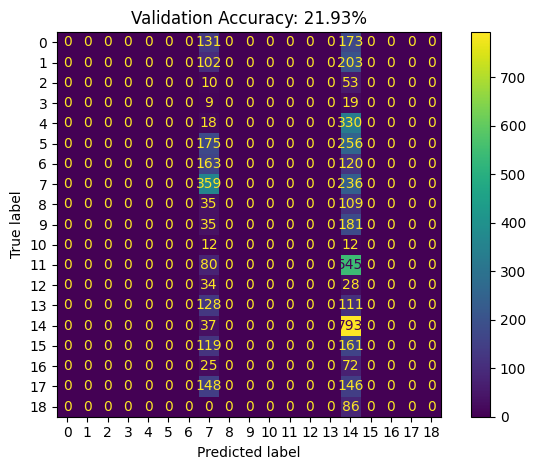

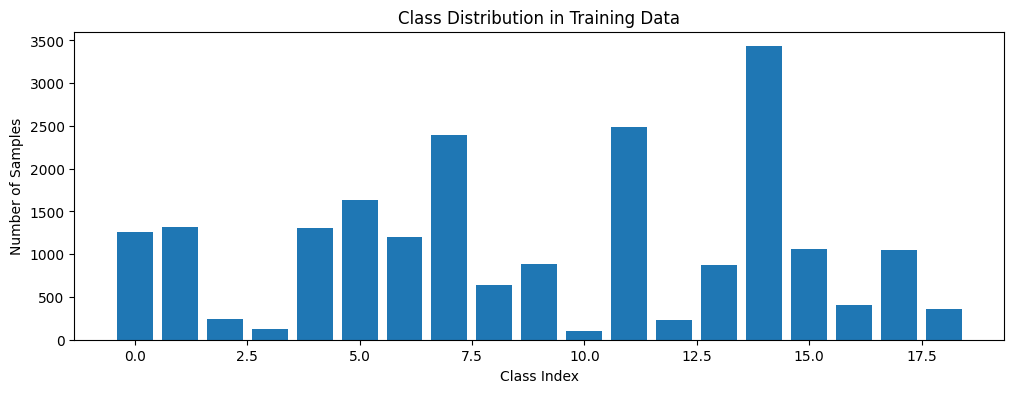


Class distribution percentages:
Class 0: 6.00%
Class 1: 6.28%
Class 2: 1.18%
Class 3: 0.59%
Class 4: 6.23%
Class 5: 7.80%
Class 6: 5.71%
Class 7: 11.39%
Class 8: 3.04%
Class 9: 4.22%
Class 10: 0.48%
Class 11: 11.81%
Class 12: 1.11%
Class 13: 4.17%
Class 14: 16.32%
Class 15: 5.07%
Class 16: 1.91%
Class 17: 5.00%
Class 18: 1.69%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       304
           1       0.00      0.00      0.00       305
           2       0.00      0.00      0.00        63
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00       348
           5       0.00      0.00      0.00       431
           6       0.00      0.00      0.00       283
           7       0.22      0.60      0.32       595
           8       0.00      0.00      0.00       144
           9       0.00      0.00      0.00       216
          10       0.00      0.00      0.00        

c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
from matplotlib import cm

# Print shapes to verify (using existing variables)
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

# Define number of classes based on labels shape
num_classes = y_train.shape[1]

# Select a single sample for prediction
sample_input = X_train[-1:]

# Get predictions using the model's predict method
sample_prediction = model.predict(sample_input, verbose=0)

# Convert predictions to class indices
prediction_classes = np.argmax(sample_prediction, axis=-1)
ground_truth = np.argmax(y_train[-1], axis=-1)

# Create a color map
# Get predictions for validation set
val_predictions = model.predict(X_val, verbose=0)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val, axis=1)

# Calculate accuracy
accuracy = np.mean(val_pred_classes == val_true_classes)

# Create a confusion matrix
cm = confusion_matrix(val_true_classes, val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Validation Accuracy: {accuracy:.2%}')
plt.tight_layout()
plt.show()
# Plot class distribution in training data
plt.figure(figsize=(12, 4))
class_counts = np.sum(y_train, axis=0)
plt.bar(range(num_classes), class_counts)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.show()

# Calculate and print class proportions
print("\nClass distribution percentages:")
for i in range(num_classes):
    percentage = (class_counts[i] / len(y_train)) * 100
    print(f"Class {i}: {percentage:.2f}%")
# Print classification report
print("\nClassification Report:")
print(classification_report(val_true_classes, val_pred_classes))

In [55]:
pre_unet.layers[2].trainable = False
pre_unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        432 │ input_layer_20[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 48)  │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 48)  │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 48)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 8)   │        384 │ block_1_depthwis

 Total params: 695,294 (2.65 MB)

 Trainable params: 680,926 (2.60 MB)

 Non-trainable params: 14,368 (56.12 KB)

In [70]:
inputs = tf.keras.layers.Input(shape=(5, 5, 40))
x = pre_unet(inputs)
x = tf.keras.layers.Conv2D(19, (1, 1), padding="same")(x)
x = tf.keras.layers.Activation("softmax")(x)

transfer_model = tf.keras.Model(inputs, x)

transfer_model.summary()




Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 5, 5, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 8, 8, 19)       │       695,294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 19)       │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 19)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695,674 (2.65 MB)

 Trainable params: 681,306 (2.60 MB)

 Non-trainable params: 14,368 (56.12 KB)

In [72]:
# Rebuild and compile the transfer model
inputs = tf.keras.layers.Input(shape=(5, 5, 40))

# Reduce channels from 40 to 3 using Conv2D
x = tf.keras.layers.Conv2D(3, kernel_size=1, padding='same')(inputs)

# Resize to match MobileNetV2's requirements
x = tf.keras.layers.Resizing(32, 32)(x)

# Load and configure base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(32, 32, 3),
    weights='imagenet',
    include_top=False
)
base_model.trainable = False

# Process through base model
x = base_model(x)

# Add classification layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(19, activation='softmax')(x)

# Create and compile model
transfer_model = tf.keras.Model(inputs=inputs, outputs=outputs)
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with all training data
history = transfer_model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

C:\Users\berky\AppData\Local\Temp\ipykernel_20676\2751282472.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.1412 - loss: 2.7358 - val_accuracy: 0.1580 - val_loss: 2.6548
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.1612 - loss: 2.6551 - val_accuracy: 0.1582 - val_loss: 2.6501
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.1620 - loss: 2.6589 - val_accuracy: 0.1584 - val_loss: 2.6409
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.1735 - loss: 2.6440 - val_accuracy: 0.1799 - val_loss: 2.6052
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.1907 - loss: 2.6012 - val_accuracy: 0.2160 - val_loss: 2.5239
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2198 - loss: 2.5124 - val_accuracy: 0.2280 - val_loss: 2.4442
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.2328 - loss: 2.4496 - val_accuracy: 0.2335 - val_loss: 2.3999
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.2396 - loss: 2.4173 - 

Epoch 1/20


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m3052754661632\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 5, 5, 40), dtype=float32)\n  • training=True\n  • mask=None'